# Markov Chain Monte Carlo (MCMC)

The probability distribution function (pdf, $p$) can be determined $p = p(\theta | x, y)$) for any given model, $\hat y(x | \theta)$ (comprising some set of parameter values, $\theta$). We have previously found models that minimize the $\chi^2$ cost function, which is the *maximum likelihood* solution. However, we will now want to draw numerous samples from the pdf in order to represent the underlying probability distributions for the parameters. *Why* these estimates are correct is the not the subject of our project (perhaps refer to [Hogg & Foreman-Mackey 2017](https://arxiv.org/abs/1710.06068) instead), but the upshot is that the Markov Chain Monte Carlo (MCMC) routines *can* reveal the parameter pdfs. That's exactly what we'll do here.

## Fitting the entire data cube simultaneously

We have previously shown how to model the spectrum and model the spatial brightness separately. Now we will combine the two results using the same functions from before. The key for this model to work is to assume that the true (astronomical) spatial brightness distribution does not vary with frequency. If that is the case, then $1d$ Gaussian spectral model will share the same amplitude as the $2d$ Gaussian spatial model.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

# all this is the same from before
root_dir = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
frequencies_fname = os.path.join(root_dir, 'data', 'frequencies.npy')
noisy_cube_fname = os.path.join(root_dir, 'data', 'noisy_cube.npy')

frequencies = np.load(frequencies_fname)
noisy_cube = np.load(noisy_cube_fname)

N_k, N_i, N_j = noisy_cube.shape

# define spatial grid
ii, jj = np.meshgrid(range(N_i), range(N_j), indexing='ij')

# estimate variances
uncertainties = np.nanstd(noisy_cube, axis=(1, 2))

In [2]:
def model_spectrum(x, *spectral_parameters):
    """Returns an array of the same length as `x` (given) that 
    produces a model of a spectrum with a flat continuum and
    single spectral emission line.
    """
    
    line_amplitude, line_frequency, line_sigma, continuum_amplitiude = spectral_parameters

    return line_amplitude * np.exp(-0.5 * (x - line_frequency)**2 / line_sigma**2) + continuum_amplitiude

def model_spatial(ii, jj, *spatial_parameters):
    """Given a grid, ii, jj, in addition to the model parameters
    which consist of the amplitude, center i and j coordinates,
    and sigma, return a circularly symmetric 2-dimensional Gaussian.
    """
    amp, i0, j0, sigma = spatial_parameters  
    
    return amp * np.exp(-0.5 * ((ii-i0)**2 + (jj-j0)**2) / sigma**2)

def chi_squared(cube_parameters, x, ii, jj, y, y_sigma):
    """Given the model parameters and data, return the
    chi-squared cost. Note that y is a data cube, y_sigma 
    is a 1d array, and x is a 1d array of frequencies.
    """
    line_amp, line_freq, line_sigma, cont_amp, i0, j0, spatial_sigma = cube_parameters
    
    # make model spectrum, then cube
    amplitudes = model_spectrum(x, line_amp, line_freq, line_sigma, cont_amp)
    model_cube = np.array([model_spatial(ii, jj, amp, i0, j0, spatial_sigma) \
                           for amp in amplitudes])
    
    return np.nansum(np.sum((y - model_cube)**2, axis=(1, 2)) / y_sigma**2)

## Minimizing $\chi^2$ using `SciPy`

In [3]:
import scipy.optimize

# make initial guesses
spectrum_params_init = [5, 97.7, 0.1, 1.5]
spatial_params_init = [14, 18, 4]

cube_params_init = spectrum_params_init + spatial_params_init

# find result
result = scipy.optimize.minimize(chi_squared, x0=cube_params_init, 
                                 args=(frequencies, ii, jj, noisy_cube, uncertainties))
params_final = result['x']

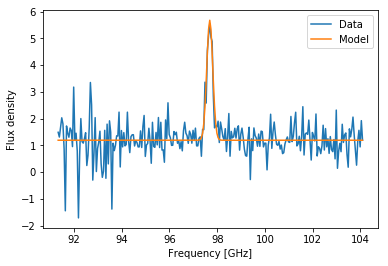

In [4]:
line_amp, line_freq, line_sigma, cont_amp, i0, j0, spatial_sigma = params_final
amplitudes = model_spectrum(frequencies, line_amp, line_freq, line_sigma, cont_amp)
model_cube = np.array([model_spatial(ii, jj, amp, i0, j0, spatial_sigma) \
                           for amp in amplitudes])

# plot results
plt.plot(frequencies, noisy_cube[:, 14, 18], label='Data')
plt.plot(frequencies, model_cube[:, 14, 18], label='Model')

plt.xlabel('Frequency [GHz]')
plt.ylabel('Flux density')
plt.legend()

## The `emcee` package

[Foreman-Mackey et al. (2013)](http://adsabs.harvard.edu/cgi-bin/bib_query?arXiv:1202.3665) have written a Python package, [`emcee`](https://github.com/dfm/emcee), for MCMC sampling. Below, we will show an example of how to use it in the context of sampling a spectral data cube.

Note that we will here be sampling the *logarithmic likelihood function*, which is simply the negative $\chi^2$ module a constant. Instead of minimizing $\chi^2$, we will be evaluating the likelihood at $-\chi^2$.

In [5]:
# define the log likelihood
log_likelihood = lambda *p: -chi_squared(*p)

In [6]:
import emcee

# write down some constants that we need for later
N_dim = len(params_final)
N_walkers = 100
N_steps = 100

# only change this if you want to parallelized processing and don't use tqdm
N_threads = 1

In [7]:
# initialize the MCMC sampler near the best-fit params
sampler = emcee.EnsembleSampler(N_walkers, N_dim, log_likelihood,
                                args=(frequencies, ii, jj, noisy_cube, uncertainties),
                                threads=N_threads)

init_pos = [params_final + 1e-4*np.random.randn(N_dim) * np.array(params_final)\
            for i in range(N_walkers)]


Now we will run the sampler, which will produce a chain of samples, and the number of samples taken in a particular location of parameter space will depend on the likelihood of that model.

In [8]:
# this lets us visualize progress
import tqdm 

for result in tqdm.tqdm_notebook(sampler.sample(init_pos, iterations=N_steps), total=N_steps):
    pass

HBox(children=(IntProgress(value=0), HTML(value='')))

In [9]:
# save the resulting samples
samples = sampler.chain.reshape((-1, N_dim))

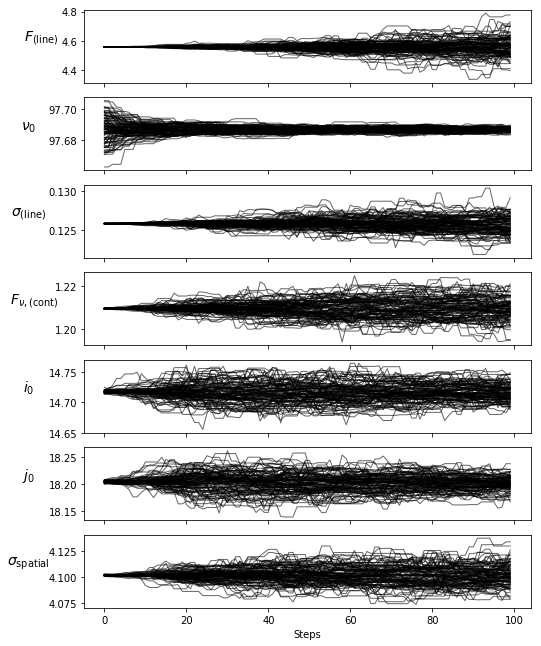

In [14]:
# give pretty names for parameters
parameter_names = [r'$F_{\rm (line)}$', r'$\nu_0$', r'$\sigma_{\rm (line)}$',
                   r'$F_{\nu, \rm (cont)}$', r'$i_0$', r'$j_0$', r'$\sigma_{\rm spatial}$']

# show how the MCMC made its way through parameter space
fig, axes = plt.subplots(N_dim, 1, sharex=True, figsize=(8, 11))
for i, [ax, param] in enumerate(zip(axes, parameter_names)):
    walkers = sampler.chain[:, :, i]
    for walker in walkers:
        ax.plot(np.arange(N_steps), walker, lw=1.0, color='k', alpha=0.6)
    ax.set_ylabel(param, rotation=0, labelpad=20, fontsize=14)

axes[N_dim-1].set_xlabel('Steps');

### Burn-in
It turns out that sometimes your sampler will need some time to warm up before it gets exploring. The steps prior to that are sometimes called the *burn-in*, and they can vary depending on the dimensionality of your model and covariances, etc. Here we can see that the first bunch of steps are not in the same locus of parameters as the last few steps. Therefore, when we determine the parameter likelihoods, we will not include the burn-in steps.

Since I didn't run the MCMC sampler for very long, we don't have many steps after burn-in. In fact, it may even be debatable whether we've reached burn-in at all, or if we need more steps. In any event, I'll assume that burn-in occupied the first 60 steps, and that steps 61-100 represent the parameter likelihoods.


In [15]:
N_burnin = 60
reshaped_samples = samples.reshape((N_walkers, N_steps, N_dim))[:, N_burnin:, :].reshape((-1, N_dim))

## Corner plots
Now I'll plot a *corner plot*, which show the parameter pdfs and bivariate distributions. I also happen to know the true parameter values (because I generated the data, *duh*), so I'll include them on this plot too.

Corner plots are helpful because you can report something like a 90% credible interval or whatever. Reporting an interval rather than a simple mean is infinitely more useful for scientific purposes.

In [16]:
import corner

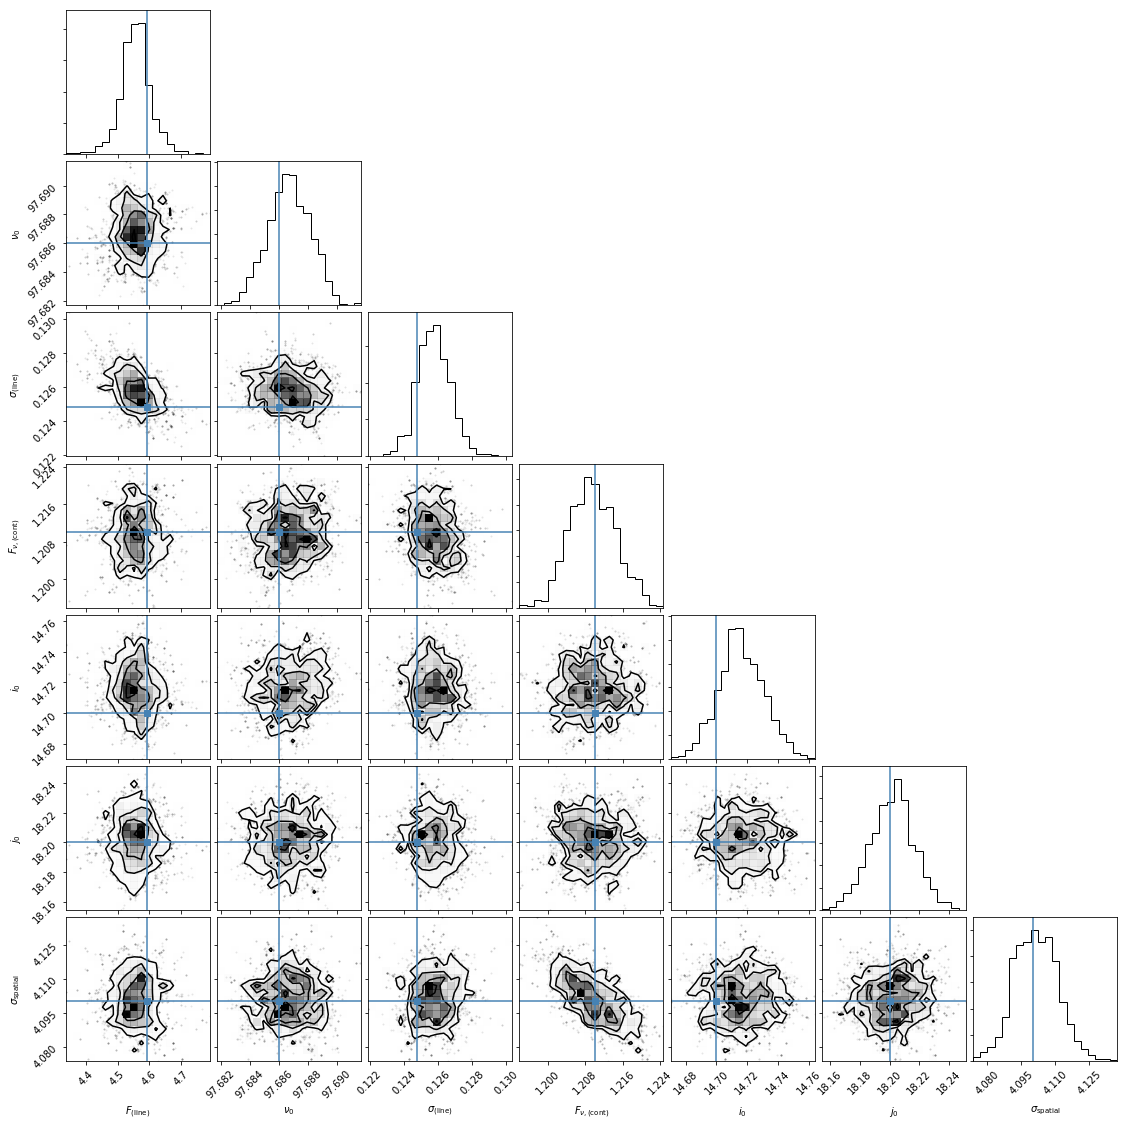

In [17]:
# plot true values
true_params = [4.592, 97.686, 0.1248, 1.21, 14.7, 18.2, 4.1]

corner.corner(reshaped_samples, labels=parameter_names, truths=true_params);